In [1]:
import condo
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
import warnings

from matplotlib.colors import LogNorm

In [2]:
N_T = 200
N_S = 100

# How confounder X affects the distribution of T and S
theta_m = 4
theta_b = 1
phi_m = 1
phi_b = 1

# How batch effect affects S
batch_m = 2
batch_b = 5
# The true batch correction from Sbatch to S
true_m = 1. / batch_m
true_b = -1 * batch_b / batch_m

In [3]:
""" normal distribution
X_T = np.random.normal(4, 1, size=(N_T,))
X_S = np.random.normal(5, 1, size=(N_S,))
"""
X_T = np.sort(np.random.uniform(0, 8, size=(N_T,1)))
X_S = np.sort(np.random.uniform(4, 8, size=(N_S,1)))

In [4]:
mu_T = theta_m * X_T + theta_b
sigma_T = phi_m * X_T + phi_b
mu_S = theta_m * X_S + theta_b
sigma_S = phi_m * X_S + phi_b
""" Confounder with nonlinear effect
mu_T = theta_m * np.maximum(X_T-5, 0) + theta_b
sigma_T = phi_m * np.maximum(X_T-5, 0) + phi_b
mu_S = theta_m * np.maximum(X_S-5, 0) + theta_b
sigma_S = phi_m * np.maximum(X_S-5, 0) + phi_b
"""

T = np.random.normal(mu_T, sigma_T)
Strue = np.random.normal(mu_S, sigma_S)
Sbatch = batch_m * Strue + batch_b

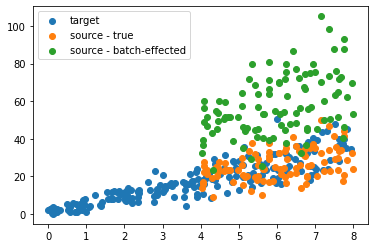

In [5]:
plt.figure()
plt.scatter(X_T, T)
plt.scatter(X_S, Strue)
plt.scatter(X_S, Sbatch)
plt.legend(['target', 'source - true', 'source - batch-effected']);

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="location-scale",
        model_type="empirical",
        divergence="mmd",
        optim_kwargs={"epochs": 10, "alpha": 0.01, "beta": 0.9},
        debug=True,
        verbose=1
    )
    cder.fit(Sbatch, T, X_S, X_T)
    Sadapted = cder.transform(Sbatch)

epoch:0 -0.42039->-0.54691 avg:-0.52453
epoch:1 -0.55433->-0.54762 avg:-0.54744
epoch:2 -0.54186->-0.54843 avg:-0.54790
epoch:3 -0.54796->-0.54680 avg:-0.54803
epoch:4 -0.54675->-0.54639 avg:-0.54755
epoch:5 -0.54995->-0.54815 avg:-0.54916
epoch:6 -0.55202->-0.55614 avg:-0.54977
epoch:7 -0.55183->-0.54638 avg:-0.55030
epoch:8 -0.55672->-0.55341 avg:-0.55040
epoch:9 -0.54800->-0.55394 avg:-0.55027
epoch:10 0.00000->0.00000 avg:0.00000
Terminating 0 after epoch 10: 0.00000


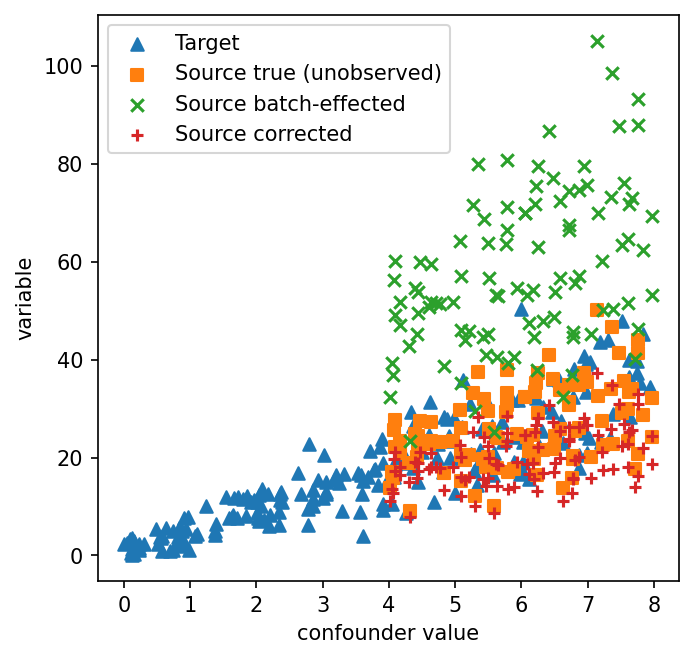

In [7]:
plt.figure(figsize=(5,5), dpi=150)
plt.scatter(X_T, T, marker='^')
plt.scatter(X_S, Strue, marker='s')
plt.scatter(X_S, Sbatch, marker='x')
plt.scatter(X_S, Sadapted, marker='+')
legend = [
    'Target',
    'Source true (unobserved)',
    'Source batch-effected',
    'Source corrected',
]
plt.legend(legend);
plt.xlabel('confounder value');
plt.ylabel('variable');

In [8]:
print(cder.M_, cder.b_)
print(batch_m, batch_b)
print(true_m, true_b)

[[0.35808317]] [-0.43209711]
2 5
0.5 -2.5


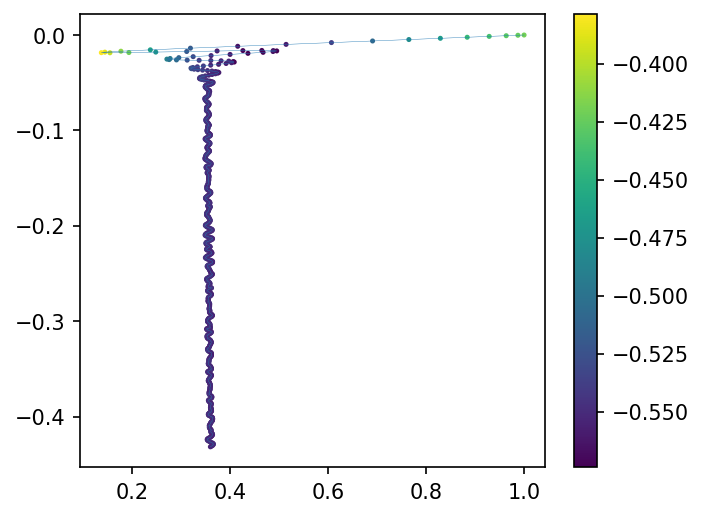

In [9]:
plt.figure(figsize=(5,4), dpi=150)
if cder.debug and cder.divergence == "mmd":
    mbos = np.vstack(cder.debug_dict_["mbos"]);
    plt.plot(mbos[:,0], mbos[:,1], linewidth=0.2);
    plt.scatter(mbos[:,0], mbos[:,1], c=mbos[:,2], s=2);
    plt.colorbar();
elif cder.debug:
    color_vals = cder.debug_dict_["mb_objs"] + 1 - np.min(cder.debug_dict_["mb_objs"])
    plt.pcolormesh(
        cder.debug_dict_["m_plot"], cder.debug_dict_["b_plot"], color_vals.T,
        norm=LogNorm(vmin=color_vals.min(), vmax=color_vals.max()));
    plt.xscale('log');
    cbar = plt.colorbar();
    cbar.ax.get_yaxis().set_ticks([color_vals.min(), color_vals.max()]);
    cbar.ax.get_yaxis().set_ticklabels(
        [int(np.round(cder.debug_dict_["mb_objs"].min())),
         int(np.round(cder.debug_dict_["mb_objs"].max()))]);
    cont = plt.contour(
        cder.debug_dict_["m_plot"], cder.debug_dict_["b_plot"], color_vals.T, 
        levels=np.geomspace(color_vals.min(), color_vals.max(), 8),
        colors='white', linestyles='solid');
    plt.ylabel('b');
    plt.xlabel('m');
    plt.scatter(true_m, true_b, marker='s', c='orange');
    plt.scatter(cder.M_[0, 0], cder.b_[0], marker='x', c='red');
    plt.tight_layout();